# NETWORK QUALITY EVALUATION PLOTS

## Comparison: METANets vs PANDA (26 tissues)
- Binding
- GO
- GO-directness
- PPI

### (i) imports, parameters, and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.ticker as ticker
import seaborn as sns
import argparse
import os
from scipy.stats import ttest_rel, ttest_ind, ttest_1samp
from matplotlib.lines import Line2D
from itertools import combinations, permutations

#####################
# pyplot parameters #
#####################
plt.rcParams['axes.labelsize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'
plt.rcParams['legend.fontsize'] = 'xx-large'
plt.rcParams['axes.titlesize'] = '20'

# MODEL PLOTTING COLOR SCHEME #
model_palette = {
    'Marbach':'tab:blue',
    'METANet':'tab:pink',
    'PANDA':'tab:cyan',
    'random permutation':'tab:gray',
    'random':'k'
}
medianprops = {
    'color':'tab:red',
    'ls': ':',
    'lw': 2
}

#################
### arguments ###
#################
parser = argparse.ArgumentParser(description="creates boxplot of evaluation results across tissues")
parser.add_argument("--results_path", default="/scratch/mblab/jungw/human_TF_project/data/xgboost_all_gtex_tissues/results/", help="results path")
parser.add_argument("--features_path", default="/scratch/mblab/jungw/human_TF_project/data/xgboost_all_gtex_tissues/input_data/", help="features path")
parser.add_argument("--binding_threshold", default=10, type=int, help="binding threshold (default=5)")
### TISSUES HAVE UPDATED TO ONLY INCLUDE 26 TISSUES IN COMMON WITH SONAWANE ET AL 2017 PANDA NETWORKS
parser.add_argument("--tissues", default="/scratch/mblab/jungw/human_TF_project/data/xgboost_all_gtex_tissues/tissues_panda_metanet_overlap.txt", help="list of tissues to include in plot")
parser.add_argument("--ppi_db_path", default="/scratch/mblab/jungw/NET-evaluation/metadata/human/9606.STRING.gencodev29_ENSG_700.txt", help="path to ppi db")
parser.add_argument("--plot_random", default=True, action='store_true', help="use to plot random and random expectation")
parser.add_argument("--output_path", default="/scratch/mblab/jungw/human_TF_project/manuscript_figures/network_quality/", help="output path to save plots")
args = parser.parse_args(args=[])

###############################
### MODEL NAMING PARAMETERS ###
###############################
# METANet and Marbach networks
models_metanet = {
    'xgboost_subset_panda':'METANet',
    'marbach':'Marbach'
}
# Sonawane et al 2017 PANDA networks
models_panda_subset = {
    'panda_subset':'PANDA'
}

In [2]:
#################
### FUNCTIONS ###
#################
def load_binding(model, path, modelname):

    df = pd.read_csv(
        os.path.join(path, f"eval_binding_{model}.tsv"),
        sep = "\t", header=None,
        names=['rank','score']
    )
    df['model'] = modelname
    return df

def load_ppi(model, path, modelname):

    if model=='xgboost_subset':
        model= 'xgboost'

    df = pd.read_csv(
        os.path.join(path, f"eval_ppi_{model}.tsv"),
        sep = "\t"
    )
    df['model'] = modelname
    return df

def load_go(model, path, modelname):

    if model=='xgboost_subset':
        model= 'xgboost'

    df_go_directness = pd.read_csv(
        os.path.join(path, f"go250_{model}_nopenalty", f"eval_go250_directness_{model}.tsv"),
        sep=",", na_values='na',
        header=None, names=['rank','score']
    )
    df_go_directness['model'] = modelname

    df_go = pd.read_csv(
        os.path.join(path, f"go250_{model}_nopenalty", f"eval_go250_{model}.tsv"),
        sep="\t", na_values='na',
    )
    df_go['rank'] = df_go_directness['rank']
    df_go['model'] = modelname

    return df_go, df_go_directness

def load_binding_permutations(results_path, tissues, features="METANet", model="xgboost", n_permutations=50):

    df_binding_permutations_list = []

    for tissue in tissues:
        eval_path = os.path.join(
            results_path, tissue, features, model, "evaluation"
        )
        for i in range(n_permutations):
            idx = i+1
            df_binding_permutation = pd.read_csv(
                os.path.join(eval_path, f"go250_{model}_nopenalty_edge_permutations", f"{tissue}_{model}_stableID_permutation{idx}_nopenalty",
                             f"eval_binding_permutation{idx}.tsv"),
                sep = "\t", header=None,
                names=['rank','score']
            )
            df_binding_permutation['model'] = 'random permutation'
            df_binding_permutation['tissue'] = tissue
            df_binding_permutation['permutation'] = idx

            df_binding_permutations_list.append(df_binding_permutation)
    
    df_binding_permutations = pd.concat(df_binding_permutations_list)

    return df_binding_permutations

def load_ppi_permutations(results_path, tissues, features="METANet", model='xgboost', n_permutations=50):

    df_ppi_permutations_list = []

    for tissue in tissues:
        eval_path = os.path.join(
            results_path, tissue, features, model, "evaluation"
        )
        for i in range(n_permutations):
            idx = i+1
            df_ppi_permutation = pd.read_csv(
                os.path.join(eval_path, f"go250_{model}_nopenalty_edge_permutations", f"{tissue}_{model}_stableID_permutation{idx}_nopenalty",
                             f"eval_ppi_permutation{idx}.tsv"),
                sep = "\t"
            )
            df_ppi_permutation['model'] = 'random permutation'
            df_ppi_permutation['tissue'] = tissue
            df_ppi_permutation['permutation'] = idx

            df_ppi_permutations_list.append(df_ppi_permutation)
    
    df_ppi_permutations = pd.concat(df_ppi_permutations_list)

    return df_ppi_permutations
        

def load_go_permutations(results_path, tissues, features="METANet", model='xgboost', n_permutations=50):

    df_go_permutations_list = []
    df_go_directness_permutations_list = []

    for tissue in tissues:
        eval_path = os.path.join(
            args.results_path, tissue, features, model, "evaluation"
        )

        for i in range(n_permutations):
            idx = i+1
            df_go_directness_permutation = pd.read_csv(
                os.path.join(eval_path, f"go250_{model}_nopenalty_edge_permutations", f"{tissue}_{model}_stableID_permutation{idx}_nopenalty", f"eval_go250_directness_{model}_permutation{idx}.tsv"),
                sep=",", na_values='na',
                header=None, names=['rank','score']
            )
            df_go_directness_permutation['tissue'] = tissue
            df_go_directness_permutation['model'] = 'random permutation'
            df_go_directness_permutation['permutation'] = idx


            df_go_permutation = pd.read_csv(
                os.path.join(eval_path, f"go250_{model}_nopenalty_edge_permutations", f"{tissue}_{model}_stableID_permutation{idx}_nopenalty", f"eval_go250_{model}_permutation{idx}.tsv"),
                sep="\t", na_values='na',
            )
            df_go_permutation['rank'] = df_go_directness_permutation['rank']
            df_go_permutation['tissue'] = tissue
            df_go_permutation['model'] = 'random permutation'
            df_go_permutation['permutation'] = idx

            df_go_permutations_list.append(df_go_permutation)
            df_go_directness_permutations_list.append(df_go_directness_permutation)

    df_go_permutations = pd.concat(df_go_permutations_list)
    df_go_directness_permutations = pd.concat(df_go_directness_permutations_list)

    # drop NA
    df_go_permutations = df_go_permutations.dropna()
    df_go_directness_permutations = df_go_directness_permutations.dropna()

    return df_go_permutations, df_go_directness_permutations



def calculate_binding_random_expectation(features_path, tissues, features="METANet"):

    list_ratio_positive = []
    for tissue in tissues:
        feature_tissue_path = os.path.join(args.features_path, tissue, features)
        df = pd.read_csv(
            os.path.join(
                feature_tissue_path,
                f"{tissue}_{features}.txt"
            ),
            sep="\t"
        )
        ratio_positive = df['LABEL'].sum() / len(df)
        list_ratio_positive.append(ratio_positive)
    avg_ratio = np.mean(list_ratio_positive) * 100 # as percentage

    return avg_ratio

def calculate_ppi_random_expectation(results_path, tissues, df_ppi, features="METANet", model="xgboost"):

    df_ppi['protein1'] = df_ppi['protein1'].str.split('.', expand=True)[0]
    df_ppi['protein2'] = df_ppi['protein2'].str.split('.', expand=True)[0]
    df_ppi = df_ppi[df_ppi['combined_score'] >= 700]
    df_ppi['tf_tf_pair'] = df_ppi['protein1'].astype(str) + '-' + df_ppi['protein2'].astype(str)
    ppi_tf_tf_pairs = set(df_ppi['tf_tf_pair'].unique())

    ppi_expectation_list = []
    for tissue in tissues:
        tissue_path = os.path.join(results_path, tissue, features)
        df = pd.read_csv(os.path.join(tissue_path, model, f"{tissue}_{model}_stableID.tsv"),
                        sep="\t", header=None, names=['TF','GENE','SCORE'])
        tfs_unique = df['TF'].unique()
        tf_tf_pairs = list(combinations(tfs_unique, 2))
        df_tf_pairs = pd.DataFrame(tf_tf_pairs, columns=['TF1','TF2'])
        df_tf_pairs['tf_tf_pair'] = df_tf_pairs['TF1'].astype(str) + '-' + df_tf_pairs['TF2'].astype(str)
        tf_tf_pairs = set(df_tf_pairs['tf_tf_pair'].unique())
        ppi_expectation = len(ppi_tf_tf_pairs.intersection(tf_tf_pairs)) / len(tf_tf_pairs)
        ppi_expectation_list.append(ppi_expectation)
        
    mean_ppi_expectation = np.mean(ppi_expectation_list) * 100 # as percentage

    return mean_ppi_expectation

def add_median_labels(ax: plt.Axes, fmt: str = ".1f") -> None:
    """Add text labels to the median lines of a seaborn boxplot.

    Args:
        ax: plt.Axes, e.g. the return value of sns.boxplot()
        fmt: format string for the median value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if "Patch" in str(c)]
    start = 4
    if not boxes:  # seaborn v0.13 => fill=False => no patches => +1 line
        boxes = [c for c in ax.get_lines() if len(c.get_xdata()) == 5]
        start += 1
    lines_per_box = len(lines) // len(boxes)
    for median in lines[start::lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if len(set(median.get_xdata())) == 1 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='white', fontsize='large', zorder=200)
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

## t-test between each pair of models ##
def ttest_per_rank(df, score_col):

    # rename score_col to score
    df = df.rename(columns={score_col:"score"})

    # sort by tissue
    df = df.sort_values(by=['tissue','model'])

    # pairs of models
    models = df['model'].unique()
    pairs = list(permutations(models, 2))
    ttest_results = {}

    for rank in df['rank'].unique():
        subset = df[df['rank'] == rank]
        for model1, model2 in pairs:
            score_model1 = subset[subset['model'] == model1].sort_values(by='tissue')['score']
            score_model2 = subset[subset['model'] == model2].sort_values(by='tissue')['score']
            if model1 == 'random permutation' or model2 == 'random permutation':
                t_stat, pval = ttest_ind(score_model1, score_model2)
            else:
                t_stat, pval = ttest_rel(score_model1, score_model2)
            ttest_results[(rank, model1, model2)] = pval

    return ttest_results

import matplotlib.pyplot as plt
from itertools import combinations

def add_significance_bars_modified(ax, rank_pval_dict, df_data, models_to_plot, score_col='score', max_y=None):
   
    def pval_to_annt(p):
        if p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        else:
            return 'ns'

    # figure out models to plot
    models_to_plot = [model for model in models_to_plot if model in df_data['model'].unique()]
    num_models = len(models_to_plot)

    # find ranks
    ranks = df_data['rank'].unique().tolist()
    y_max = df_data[score_col].max()
    if max_y is not None and y_max > max_y:
        y_max = max_y
    small_y = y_max < 16
    
    for i, rank in enumerate(ranks):

        dict_x_positions = {}
        # get base y position
        y_gap = y_max * 0.03
        if small_y:
            y_gap = y_max * 0.05
        y_base = df_data[df_data['rank'] == rank][score_col].max()
        if max_y is not None and y_base > max_y:
            y_base = max_y + 0.5
        y_base = y_base + y_gap

        for j, model in enumerate(models_to_plot):
            
            # get x positions of each model boxplot
            if num_models % 2 == 0:
                dict_x_positions[model] = i + (-0.3) + (0.2 * j)
            else:
                dict_x_positions[model] = i + (-0.25 * ((num_models-1)/2)) + (0.25 * j)
            # y offset between each sig bar
            y_offset = y_max * 0.03
            if small_y:
                y_offset = y_max * 0.02

        model_pair = combinations(models_to_plot, 2)
        for p, (model1, model2) in enumerate(model_pair):
            # print(model1, model2)

            # plot only if significant
            pval = rank_pval_dict[(rank,model1,model2)]
            if pval > 0.05:
                continue
            if model1 != 'METANet':
                continue
            pval_annt = pval_to_annt(pval)

            x1 = dict_x_positions[model1]
            x2 = dict_x_positions[model2]
            x_text = (x1+x2) / 2
            y1 = y_base + (y_offset * p)
            y2 = y_base + (y_offset * (p+1))
            y_base = y_base + y_gap

            ax.plot([x1, x1, x2, x2], [y1, y2, y2, y1], lw=0.5, c='black', zorder=200)
            ax.text(x_text, y2, pval_annt, ha='center', va='center', fontsize=5, zorder=201)

### (ii) load data

#### load random

In [3]:
# load tissues
all_tissues = np.loadtxt(args.tissues, dtype=str)
print(f" - found {len(all_tissues)} tissues")

if args.plot_random:
    # calculate binding expectation
    print("calculating binding random expectation")
    binding_random_expectation = calculate_binding_random_expectation(args.features_path, all_tissues, features="METANet")
    print(binding_random_expectation)

    # calculate ppi expectation
    # load ppi db
    print("calculating ppi random expectation")
    df_ppi = pd.read_csv(args.ppi_db_path, sep=" ")
    ppi_random_expectation = calculate_ppi_random_expectation(args.results_path, all_tissues, df_ppi, features="METANet", model="xgboost_subset_panda")
    print(ppi_random_expectation)
    del df_ppi

    # calculate go/godirectness random expectations
    print("loading GO/GO-directness permutations")
    df_go_random, df_go_directness_random = load_go_permutations(args.results_path, all_tissues, features="METANet", model="xgboost_subset_panda")
        
    # calculate binding random permutations
    print("loading binding permutations")
    df_binding_random_permutation = load_binding_permutations(args.results_path, all_tissues, features="METANet", model="xgboost_subset_panda")
    
    # calculate ppi random permutations
    print("loading ppi permutations")
    df_ppi_random_permutation = load_ppi_permutations(args.results_path, all_tissues, features="METANet", model="xgboost_subset_panda")

 - found 26 tissues
calculating binding random expectation
8.684679994135022
calculating ppi random expectation
3.7142644905743603
loading GO/GO-directness permutations
loading binding permutations
loading ppi permutations


#### load evaluation results

In [4]:
print("load eval results")
df_binding_list = []
df_go_directness_list = []
df_go_list = []
df_ppi_list = []

for tissue in all_tissues:
    print(tissue)
    tissue_metanet_path = os.path.join(args.results_path, tissue, "METANet")
    tissue_panda_subset_path = os.path.join(args.results_path, tissue, "benchmark_networks")

    df_binding_model_list = []
    df_go_model_list = []
    df_go_directness_model_list = []
    df_ppi_model_list = []

    ## METANET + MARBACH ##
    for model in models_metanet.keys():
        model_path = os.path.join(tissue_metanet_path, model, 'evaluation')

        # load binding
        df_binding = load_binding(model, model_path, models_metanet[model])

        # load ppi
        df_ppi = load_ppi(model, model_path, models_metanet[model])

        # load go and go-directness
        df_go, df_go_directness = load_go(model, model_path, models_metanet[model])

        # append to lists
        df_binding_model_list.append(df_binding)
        df_ppi_model_list.append(df_ppi)
        df_go_model_list.append(df_go)
        df_go_directness_model_list.append(df_go_directness)
    
    ## SONAWANE ET AL 2017 PANDA NETWORKS ##
    for model in models_panda_subset.keys():
        model_path = os.path.join(tissue_panda_subset_path, model, 'evaluation')

        # load binding
        df_binding = load_binding(model, model_path, models_panda_subset[model])

        # load ppi
        df_ppi = load_ppi(model, model_path, models_panda_subset[model])

        # load go and go-directness
        df_go, df_go_directness = load_go(model, model_path, models_panda_subset[model])

        # append to lists
        df_binding_model_list.append(df_binding)
        df_ppi_model_list.append(df_ppi)
        df_go_model_list.append(df_go)
        df_go_directness_model_list.append(df_go_directness)

    df_binding_tissue = pd.concat(df_binding_model_list)
    df_binding_tissue['tissue'] = tissue
    df_binding_list.append(df_binding_tissue)

    df_go_directness_tissue = pd.concat(df_go_directness_model_list)
    df_go_directness_tissue['tissue'] = tissue
    df_go_directness_list.append(df_go_directness_tissue)

    df_go_tissue = pd.concat(df_go_model_list)
    df_go_tissue['tissue'] = tissue
    df_go_list.append(df_go_tissue)

    df_ppi_tissue = pd.concat(df_ppi_model_list)
    df_ppi_tissue['tissue'] = tissue
    df_ppi_list.append(df_ppi_tissue)


load eval results
adipose_subcutaneous
adipose_visceral_omentum
artery_aorta
artery_coronary
artery_tibial
brain_cerebellum
breast_mammary_tissue
colon_transverse
esophagus_mucosa
esophagus_muscularis
heart_left_ventricle
liver
lung
muscle_skeletal
nerve_tibial
ovary
pancreas
pituitary
prostate
spleen
stomach
testis
thyroid
uterus
vagina
whole_blood


### (iii) evaluation result processing

#### subset for avg targets/TF thresholds

In [5]:
# concat
df_binding = pd.concat(df_binding_list)
df_go = pd.concat(df_go_list)
df_go_directness = pd.concat(df_go_directness_list)
df_ppi = pd.concat(df_ppi_list)

# subset for specific thresholds
subset_ranks = [50,100,250]
subset_ranks_ppi = [50,100]
df_binding = df_binding[df_binding['rank'].isin(subset_ranks)]
df_go = df_go[df_go['rank'].isin(subset_ranks)]
df_go_directness = df_go_directness[df_go_directness['rank'].isin(subset_ranks)]
df_ppi = df_ppi[df_ppi['rank'].isin(subset_ranks_ppi)]


if args.plot_random:
    # subset permutations for thresholds
    df_go_random = df_go_random[df_go_random['rank'].isin(subset_ranks)]
    df_go_directness_random = df_go_directness_random[df_go_directness_random['rank'].isin(subset_ranks)]
    
    # subset binding permutations for thresholds
    df_binding_random_permutation = df_binding_random_permutation[df_binding_random_permutation['rank'].isin(subset_ranks)]
    
    # subset ppi permutations for thresholds
    df_ppi_random_permutation = df_ppi_random_permutation[df_ppi_random_permutation['rank'].isin(subset_ranks_ppi)]

df_binding = df_binding.sort_values(by=['model','tissue'])

#### t-test between models for matching tissues

In [6]:
dict_binding_ttest = ttest_per_rank(df_binding, score_col="score")
dict_ppi_ttest = ttest_per_rank(df_ppi, score_col="ppi_support")
dict_go_ttest = ttest_per_rank(df_go, score_col="median")
dict_go_directness_ttest = ttest_per_rank(df_go_directness, score_col="score")

In [7]:
### MODELS TO PLOT ###
models_to_plot = ['METANet','Marbach','PANDA','random permutation']

In [8]:
df_binding_final = df_binding[df_binding['model'].isin(models_to_plot)]
df_go_final = df_go[df_go['model'].isin(models_to_plot)]
df_go_directness_final = df_go_directness[df_go_directness['model'].isin(models_to_plot)]
df_ppi_final = df_ppi[df_ppi['model'].isin(models_to_plot)]

dict_binding_ttest_final = ttest_per_rank(df_binding_final, score_col="score")
dict_ppi_ttest_final = ttest_per_rank(df_ppi_final, score_col="ppi_support")
dict_go_ttest_final = ttest_per_rank(df_go_final, score_col="median")
dict_go_directness_ttest_final = ttest_per_rank(df_go_directness_final, score_col="score")

# go and go_directness: include random permutations
df_go_final_random = pd.concat([df_go_final, df_go_random])
dict_go_ttest_final_random = ttest_per_rank(df_go_final_random, score_col="median")
 
df_go_directness_final_random = pd.concat([df_go_directness_final, df_go_directness_random])
dict_go_directness_ttest_final_random = ttest_per_rank(df_go_directness_final_random, score_col="median")

# binding: include random permutations
df_binding_final_random = pd.concat([df_binding_final, df_binding_random_permutation])
dict_binding_ttest_final_random = ttest_per_rank(df_binding_final_random, score_col='score')

# ppi: include random permutations
df_ppi_final_random = pd.concat([df_ppi_final, df_ppi_random_permutation])
dict_ppi_ttest_final_random = ttest_per_rank(df_ppi_final_random, score_col='ppi_support')

### plot with legends

In [9]:
import matplotlib.pyplot as plt
from itertools import combinations

def add_significance_bars_modified(ax, rank_pval_dict, df_data, models_to_plot, score_col='score', max_y=None):
   
    def pval_to_annt(p):
        if p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        else:
            return 'ns'

    # figure out models to plot
    models_to_plot = [model for model in models_to_plot if model in df_data['model'].unique()]
    num_models = len(models_to_plot)

    # find ranks
    ranks = df_data['rank'].unique().tolist()
    y_max = df_data[score_col].max()
    if max_y is not None and y_max > max_y:
        y_max = max_y
    small_y = y_max < 16
    
    for i, rank in enumerate(ranks):

        dict_x_positions = {}
        # get base y position
        y_gap = y_max * 0.03
        if small_y:
            y_gap = y_max * 0.05
        y_base = df_data[df_data['rank'] == rank][score_col].max()
        if max_y is not None and y_base > max_y:
            y_base = max_y + 0.5
        y_base = y_base + y_gap

        for j, model in enumerate(models_to_plot):
            
            # get x positions of each model boxplot
            if num_models % 2 == 0:
                dict_x_positions[model] = i + (-0.3) + (0.2 * j)
            else:
                dict_x_positions[model] = i + (-0.25 * ((num_models-1)/2)) + (0.25 * j)
            # y offset between each sig bar
            y_offset = y_max * 0.02
            if small_y:
                y_offset = y_max * 0.02

        model_pair = combinations(models_to_plot, 2)
        for p, (model1, model2) in enumerate(model_pair):
            # print(model1, model2)

            # plot only if significant
            pval = rank_pval_dict[(rank,model1,model2)]
            if pval > 0.05:
                continue
            if model1 != 'METANet':
                continue
            pval_annt = pval_to_annt(pval)

            x1 = dict_x_positions[model1]
            x2 = dict_x_positions[model2]
            x_text = (x1+x2) / 2
            y1 = y_base + (y_offset * p)
            y2 = y_base + (y_offset * (p+1))
            y_base = y_base + y_gap

            ax.plot([x1, x1, x2, x2], [y1, y2, y2, y1], lw=0.5, c='black', zorder=200)
            ax.text(x_text, y2, pval_annt, ha='center', va='bottom', fontsize=5, zorder=201)


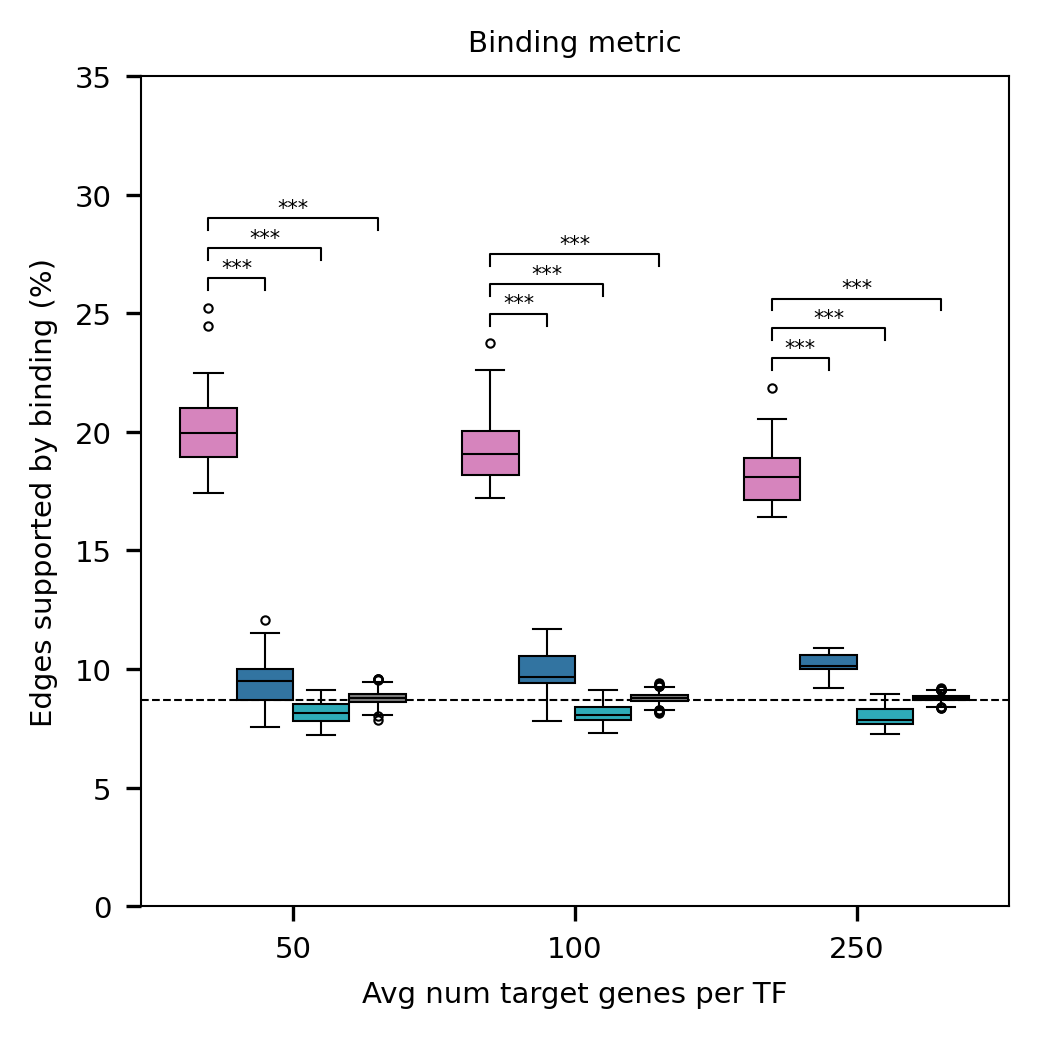

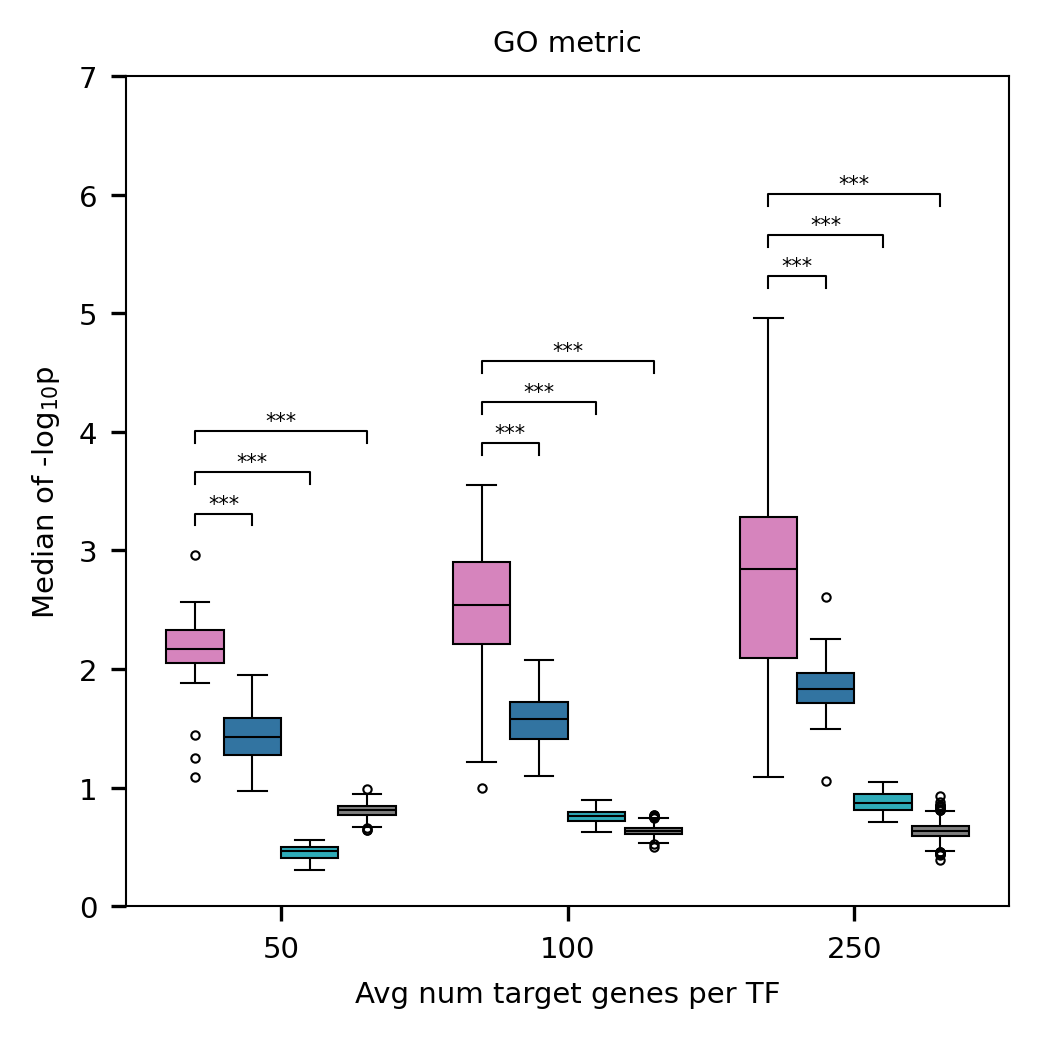

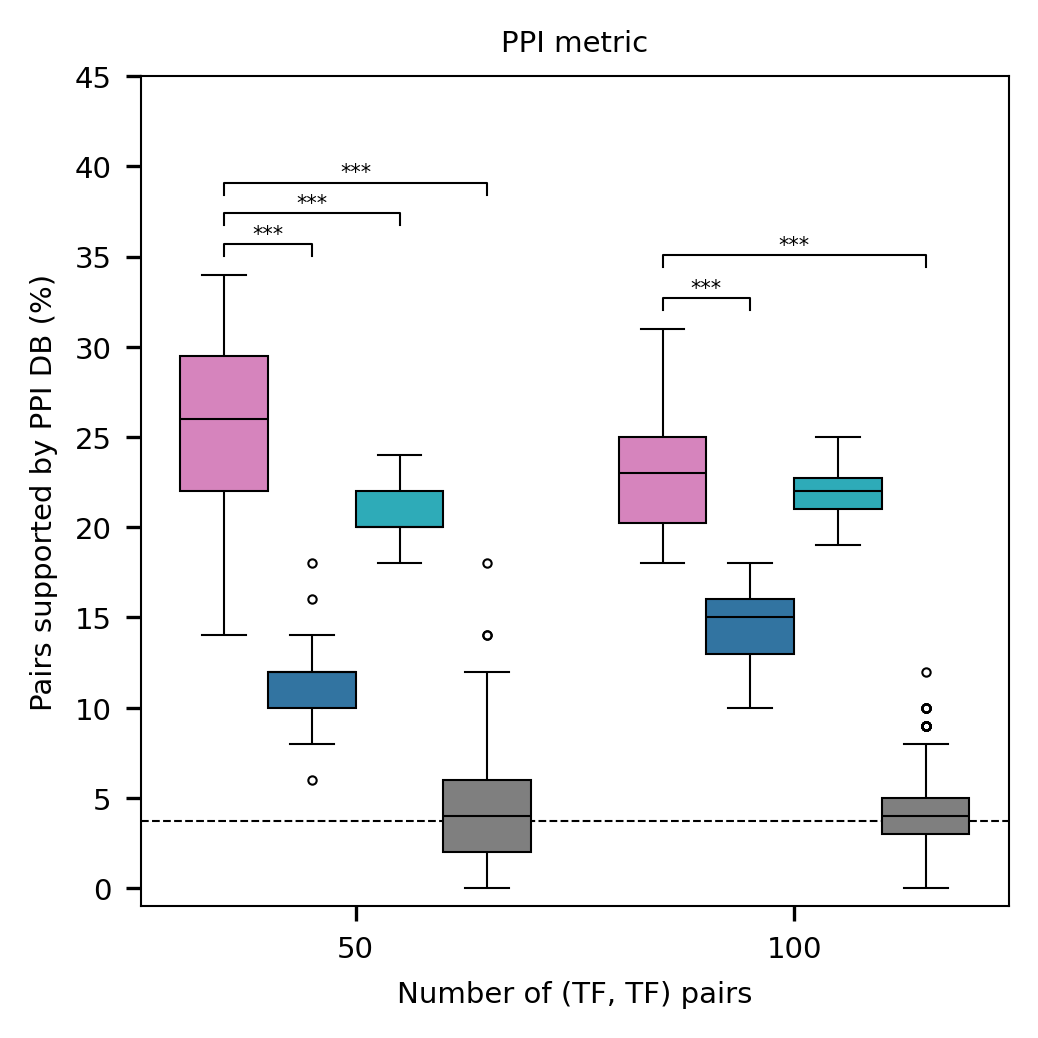

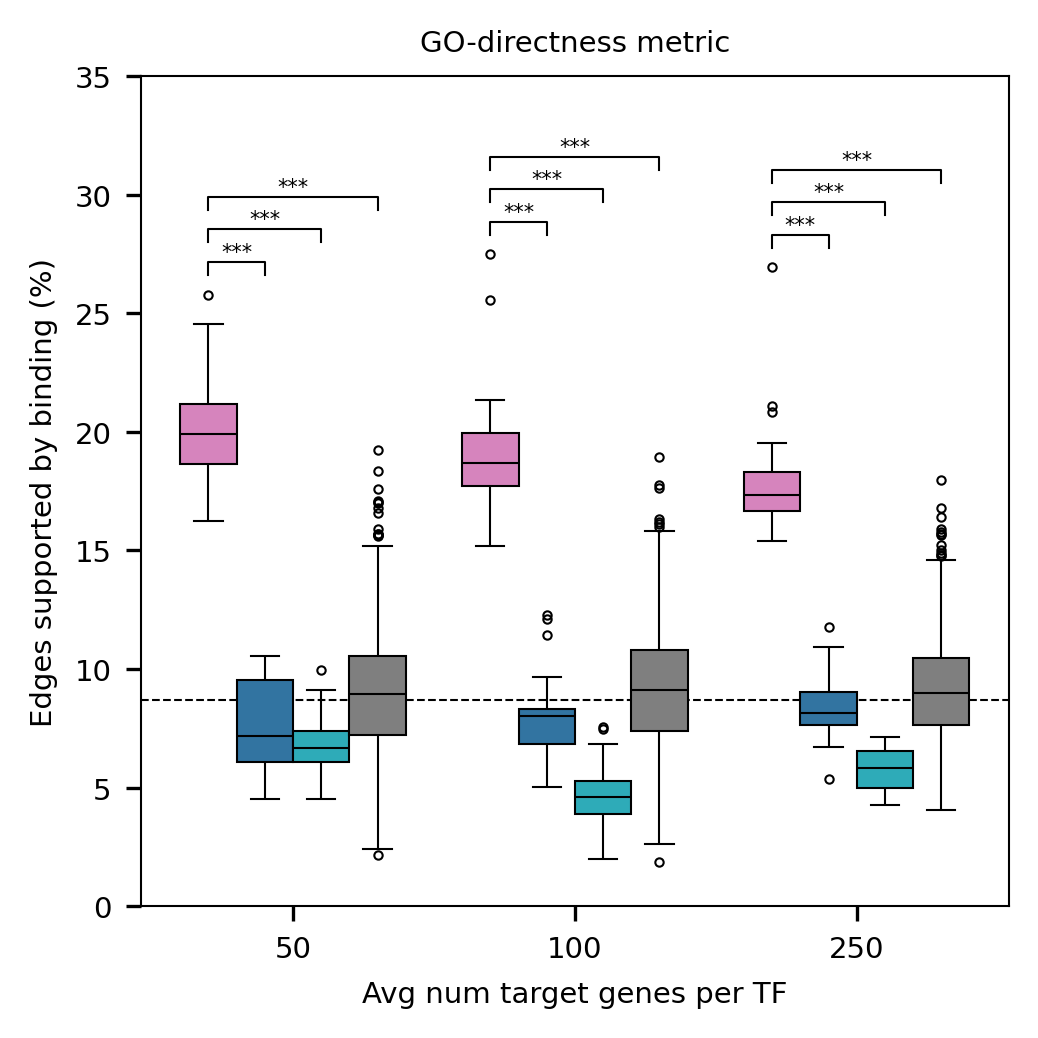

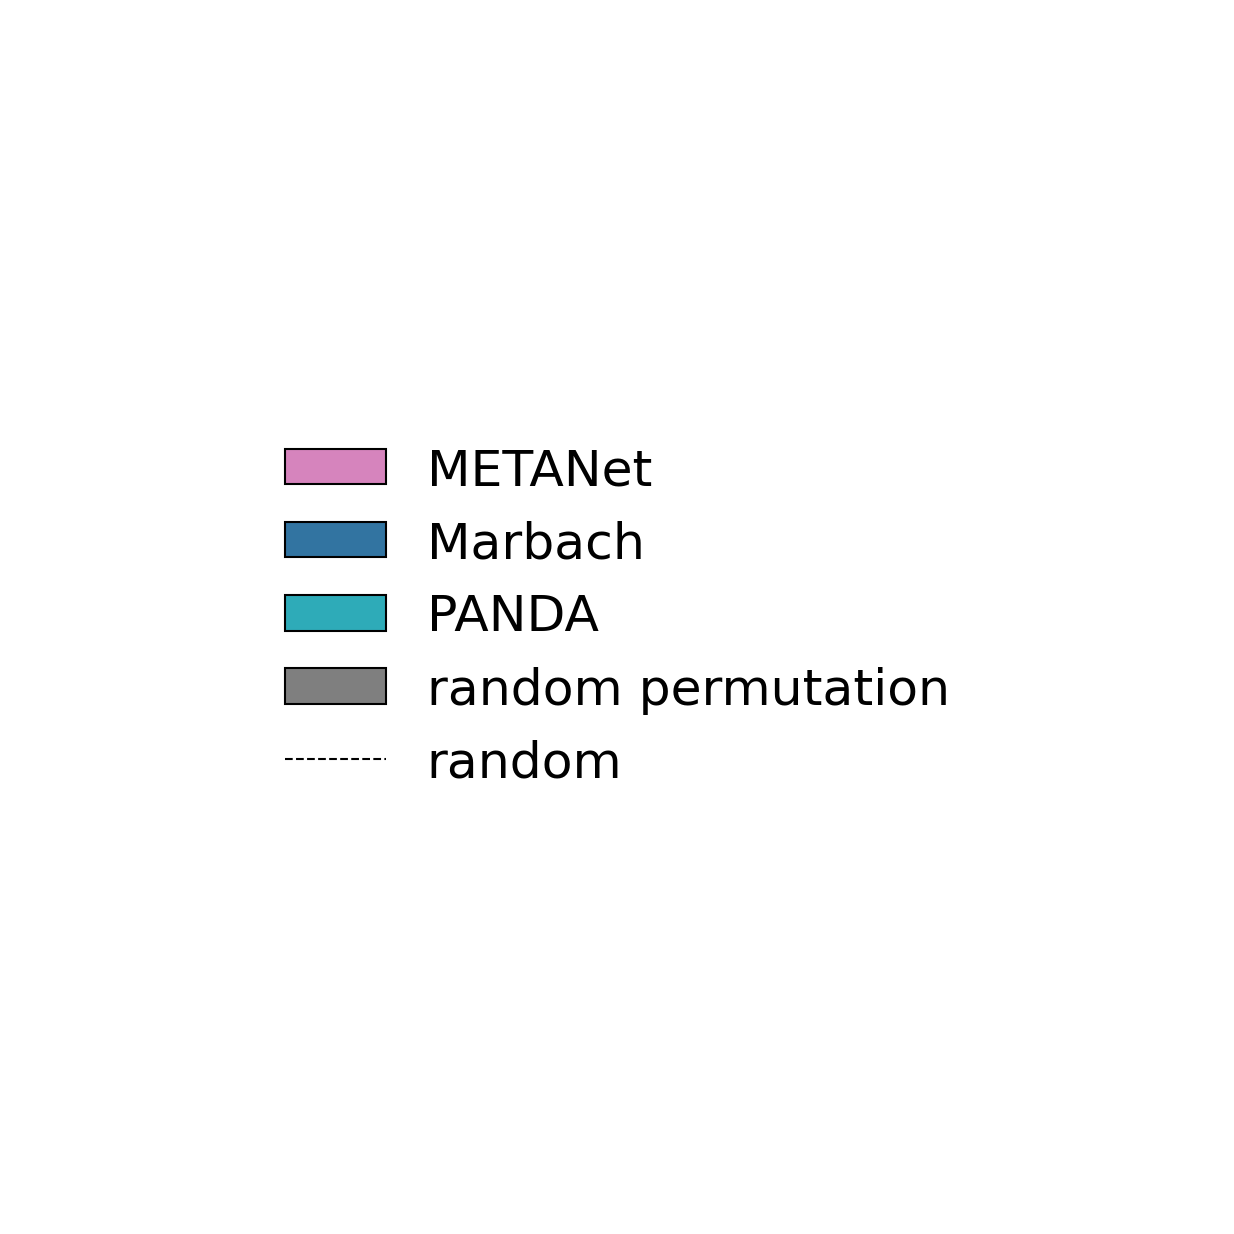

In [10]:
import matplotlib as mpl
import matplotlib.ticker as mticker

mpl.rcParams.update({
    # Use final physical size so text/lines are correct at submission size
    "figure.dpi": 300,          # affects rasterized bits only; OK to keep 300
    "savefig.dpi": 300,

    # Typography: readable at final size
    "font.family": "sans-serif",   # swap to Helvetica/Arial if you have them
    "font.size": 7,                  # axis/legend 8–9 pt; set per-artist as needed
    "axes.titlesize": 7,
    "axes.labelsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,

    # Lines and markers
    "lines.linewidth": 0.5,     # in points; ≥0.5 pt per journal spec
    "axes.linewidth": 0.5,
    "grid.linewidth": 0.5,

    # Layout
    "figure.constrained_layout.use": True,  # better than tight_layout for panels
    "figure.autolayout": False,

    # Embed fonts as text (don’t outline)
    "pdf.fonttype": 42,         # TrueType
    "ps.fonttype": 42,
    "svg.fonttype": "none",     # keep text as <text>, not paths
})

W_FULL_inch = 170 / 25.4 # 170mm in inches
gutter_mm = 0
gutter_inch = gutter_mm / 25.4
panel_width_mm = (170 - (2 - 1) * gutter_mm)     # 4 panels with 3mm gutters
per_panel_mm = panel_width_mm / 2                # 4 panels, but PPI panel is twice the width of others
per_panel_inch = per_panel_mm / 25.4

flierprops = dict(marker='o', markersize=2,   # default ~6
                  linestyle='none', markeredgewidth=0.5)

## AX1 -- BINDING
fig1, ax1 = plt.subplots(figsize=(per_panel_inch,per_panel_inch), constrained_layout=True)
models_to_plot_binding = ['METANet','Marbach','PANDA','random permutation']
sns.boxplot(data = df_binding_final_random, x = 'rank', y = 'score', hue = 'model', hue_order=models_to_plot_binding, 
            palette=model_palette, zorder=100, legend=False, 
            flierprops=flierprops, 
            boxprops=dict(linewidth=0.5),
            whiskerprops=dict(linewidth=0.5),
            capprops=dict(linewidth=0.5),
            medianprops=dict(linewidth=0.5))
if args.plot_random:
    ax1.axhline(binding_random_expectation, ls='--', label='random', c='k')
add_significance_bars_modified(ax1, dict_binding_ttest_final_random, df_binding_final_random, models_to_plot_binding)
ax1.set_title(f"Binding metric")
ax1.set_ylabel("Edges supported by binding (%)")
ax1.set_xlabel("Avg num target genes per TF")
ax1.set_ylim(bottom=0, top=35)


## AX2 -- GO
fig2, ax2 = plt.subplots(figsize=(per_panel_inch,per_panel_inch), constrained_layout=True)
models_to_plot_go = ['METANet','Marbach','PANDA','random permutation']
sns.boxplot(data = df_go_final_random, x = 'rank', y = 'median', hue = 'model', hue_order=models_to_plot_go,
            palette=model_palette, zorder=100, legend=False, 
            flierprops=flierprops, 
            boxprops=dict(linewidth=0.5),
            whiskerprops=dict(linewidth=0.5),
            capprops=dict(linewidth=0.5),
            medianprops=dict(linewidth=0.5))
add_significance_bars_modified(ax2, dict_go_ttest_final_random, df_go_final_random, models_to_plot_go, score_col='median')
ax2.set_title(f"GO metric")
ax2.set_ylabel("Median of -$\mathrm{log}_{10}$p")
ax2.set_xlabel("Avg num target genes per TF")
ax2.set_ylim(bottom=0, top=7)


## AX3 -- PPI
fig3, ax3 = plt.subplots(figsize=(per_panel_inch,per_panel_inch), constrained_layout=True)
models_to_plot_ppi = ['METANet','Marbach','PANDA','random permutation']
sns.boxplot(data = df_ppi_final_random, x = 'rank', y = 'ppi_support', hue = 'model', hue_order=models_to_plot_ppi,
            palette=model_palette, zorder=100, legend=False,
            flierprops=flierprops, 
            boxprops=dict(linewidth=0.5),
            whiskerprops=dict(linewidth=0.5),
            capprops=dict(linewidth=0.5),
            medianprops=dict(linewidth=0.5))
if args.plot_random:
    ax3.axhline(ppi_random_expectation, ls='--', label='random', c='k')
add_significance_bars_modified(ax3, dict_ppi_ttest_final_random, df_ppi_final_random, models_to_plot_ppi, score_col='ppi_support')
ax3.set_title(f"PPI metric")
ax3.set_ylabel("Pairs supported by PPI DB (%)")
ax3.set_xlabel("Number of (TF, TF) pairs")
ax3.set_ylim(bottom=-1, top=45)
ax3.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))


## AX4 GO-DIRECTNESS
fig4, ax4 = plt.subplots(figsize=(per_panel_inch,per_panel_inch), constrained_layout=True)
models_to_plot_go_directness = ['METANet','Marbach','PANDA','random permutation']
sns.boxplot(data = df_go_directness_final_random, x = 'rank', y = 'score', hue = 'model', hue_order=models_to_plot_go_directness,
            palette=model_palette, zorder=100, legend=True,
            flierprops=flierprops, 
            boxprops=dict(linewidth=0.5),
            whiskerprops=dict(linewidth=0.5),
            capprops=dict(linewidth=0.5),
            medianprops=dict(linewidth=0.5))
ax4.axhline(binding_random_expectation, ls='--', label='random', c='k')
ax4.get_legend().set_title(None)
ax4.legend(fontsize='xx-large')
add_significance_bars_modified(ax4, dict_go_directness_ttest_final_random, df_go_directness_final_random, models_to_plot_go_directness)
ax4.set_title(f"GO-directness metric")
ax4.set_ylabel("Edges supported by binding (%)")
ax4.set_xlabel("Avg num target genes per TF")
ax4.set_ylim(bottom=0, top=35)

# save legend only
# pull legend artists from ax4
handles, labels = ax4.get_legend_handles_labels()

# make a new figure just for the legend
fig_leg = plt.figure(figsize=(4, 4))
# create a single, empty Axes and turn the axis off
ax_leg = fig_leg.add_subplot(111)
ax_leg.axis('off')

# draw the legend centered in the new figure
leg = ax_leg.legend(handles, labels,
                    loc='center',
                    ncol=1,               # or more columns if you like
                    fontsize='xx-large',  # match your original fontsize
                    frameon=False)        # optional: turn off the legend frame

ax4.get_legend().remove()
plt.show()
